<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [85]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [87]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [88]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [89]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [90]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            # nn.Flatten(),
            # nn.LazyLinear(10),
            nn.Conv2d(1, 10, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 5, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(5),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [91]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [92]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [93]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 20

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [94]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [95]:
from torchsummary import summary
model = Module().to(device)
summary(model, (1, 28, 28))

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 14, 14]             100
         MaxPool2d-2             [-1, 10, 7, 7]               0
              ReLU-3             [-1, 10, 7, 7]               0
       BatchNorm2d-4             [-1, 10, 7, 7]              20
            Conv2d-5              [-1, 5, 4, 4]             455
         MaxPool2d-6              [-1, 5, 2, 2]               0
              ReLU-7              [-1, 5, 2, 2]               0
       BatchNorm2d-8              [-1, 5, 2, 2]              10
           Flatten-9                   [-1, 20]               0
           Linear-10                   [-1, 10]             210
Total params: 795
Trainable params: 795
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Siz

 - Task 0

Accuracy 0.6531
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.78      0.73      0.75       980
     1 - one       0.64      0.96      0.77      1135
     2 - two       0.55      0.87      0.67      1032
   3 - three       0.70      0.73      0.72      1010
    4 - four       0.38      0.23      0.29       982
    5 - five       0.71      0.65      0.68       892
     6 - six       0.55      0.49      0.51       958
   7 - seven       0.95      0.47      0.63      1028
   8 - eight       0.64      0.79      0.71       974
    9 - nine       0.82      0.56      0.66      1009

    accuracy                           0.65     10000
   macro avg       0.67      0.65      0.64     10000
weighted avg       0.67      0.65      0.64     10000



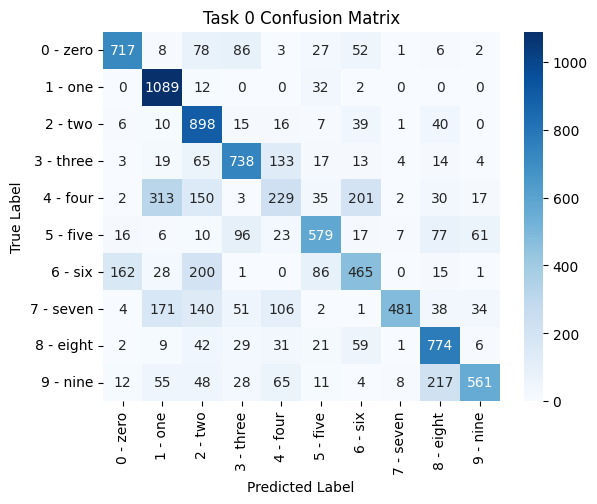

In [96]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.6208
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.64      0.79      0.71       980
     1 - one       0.79      0.95      0.86      1135
     2 - two       0.53      0.39      0.45      1032
   3 - three       0.53      0.50      0.51      1010
    4 - four       0.65      0.55      0.60       982
    5 - five       0.56      0.43      0.49       892
     6 - six       0.62      0.69      0.65       958
   7 - seven       0.66      0.68      0.67      1028
   8 - eight       0.53      0.55      0.54       974
    9 - nine       0.59      0.63      0.61      1009

    accuracy                           0.62     10000
   macro avg       0.61      0.62      0.61     10000
weighted avg       0.61      0.62      0.61     10000



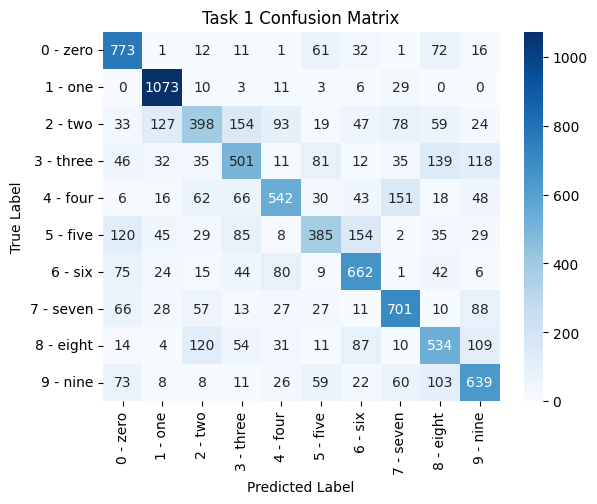

In [97]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.0.weight
torch.Size([10, 1, 3, 3])
Max fisher is 0.31943 and it's parameter diff is 0.00147
Min Parameter diff is 0.07522 and it's fisher is 0.04053
fisher > parameter diff: 6
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

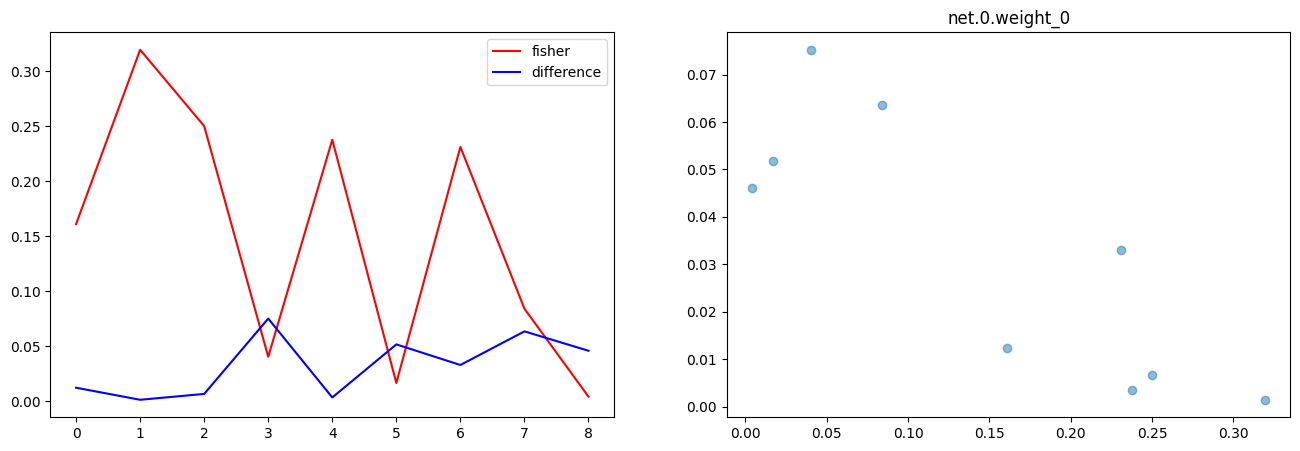

Max fisher is 1.50151 and it's parameter diff is 0.00095
Min Parameter diff is 0.03360 and it's fisher is 0.04762
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

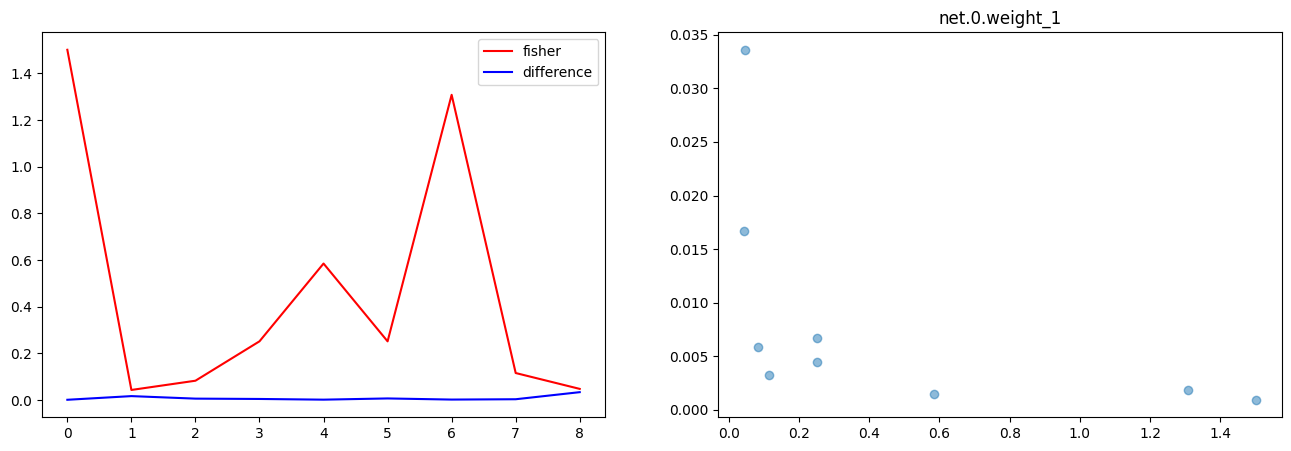

Max fisher is 2.37539 and it's parameter diff is 0.00316
Min Parameter diff is 0.05420 and it's fisher is 0.11517
fisher > parameter diff: 6
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

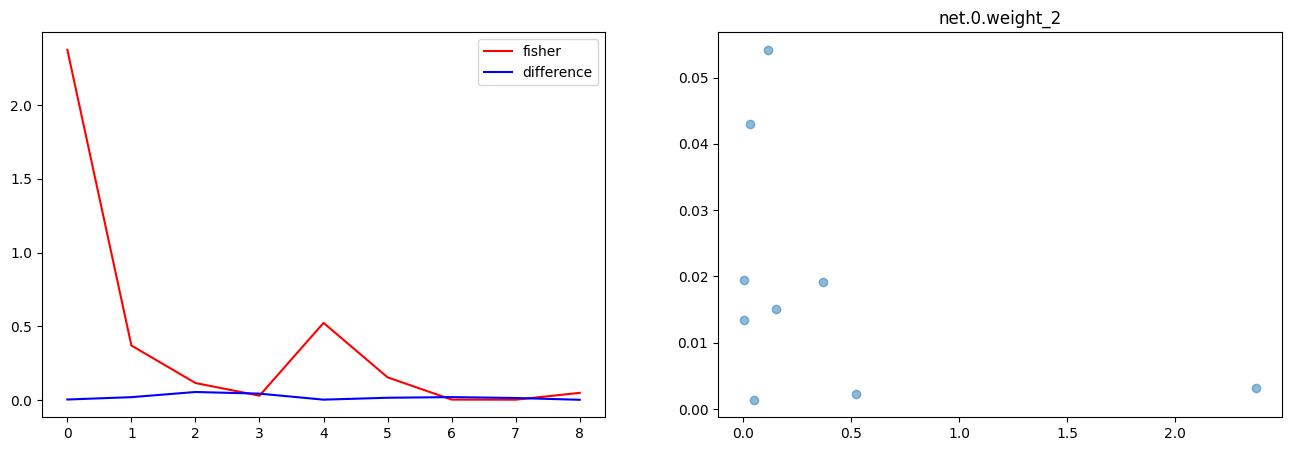

Max fisher is 0.19053 and it's parameter diff is 0.02664
Min Parameter diff is 0.41548 and it's fisher is 0.00249
fisher > parameter diff: 4
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

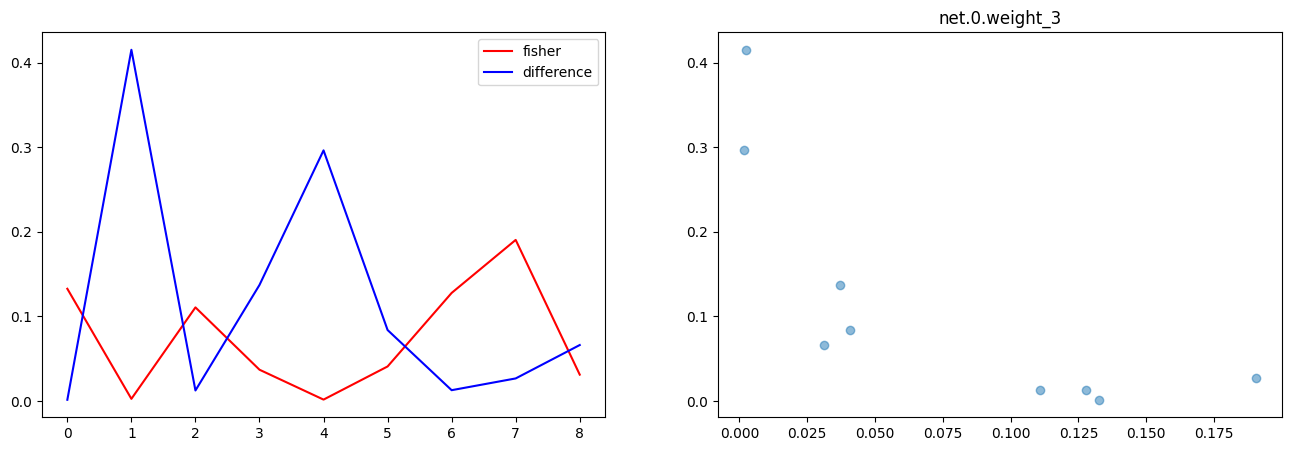

Max fisher is 1.21509 and it's parameter diff is 0.00189
Min Parameter diff is 0.02130 and it's fisher is 0.06918
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

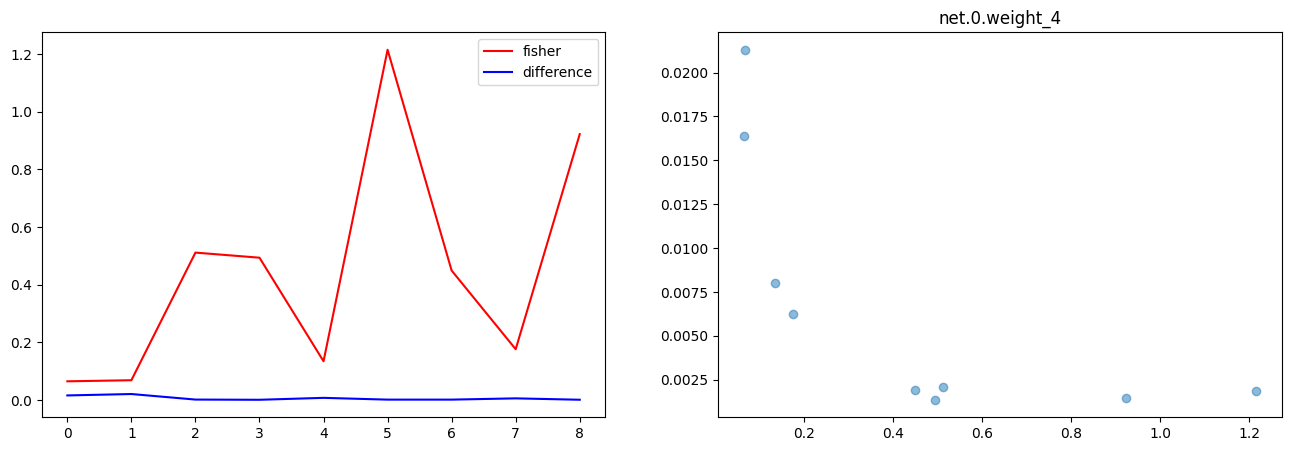

Max fisher is 0.05255 and it's parameter diff is 0.02275
Min Parameter diff is 0.06154 and it's fisher is 0.00989
fisher > parameter diff: 4
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

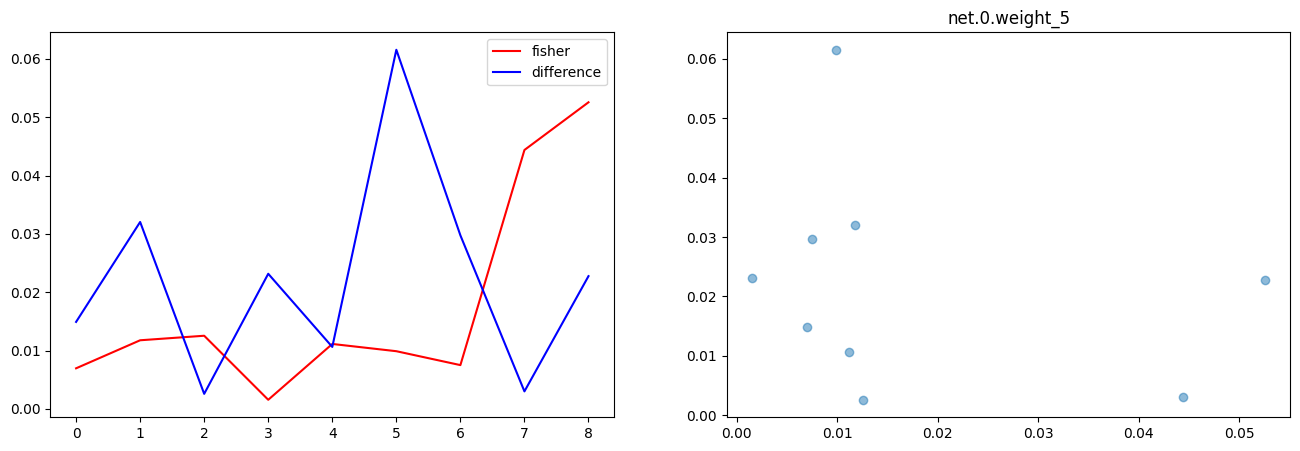

Max fisher is 2.31786 and it's parameter diff is 0.00047
Min Parameter diff is 0.01368 and it's fisher is 0.20304
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

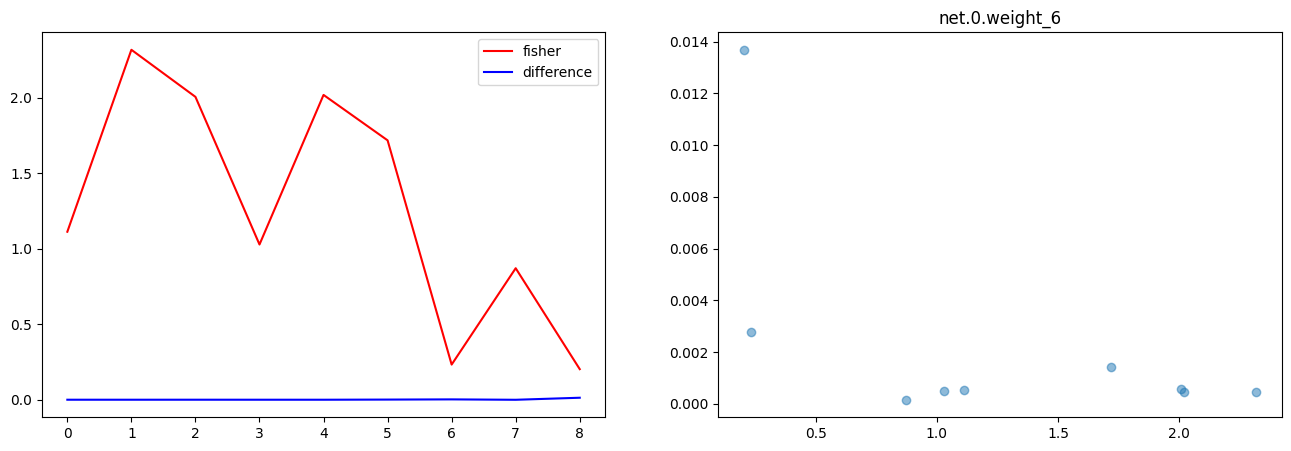

Max fisher is 0.88384 and it's parameter diff is 0.00388
Min Parameter diff is 0.15281 and it's fisher is 0.01122
fisher > parameter diff: 6
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

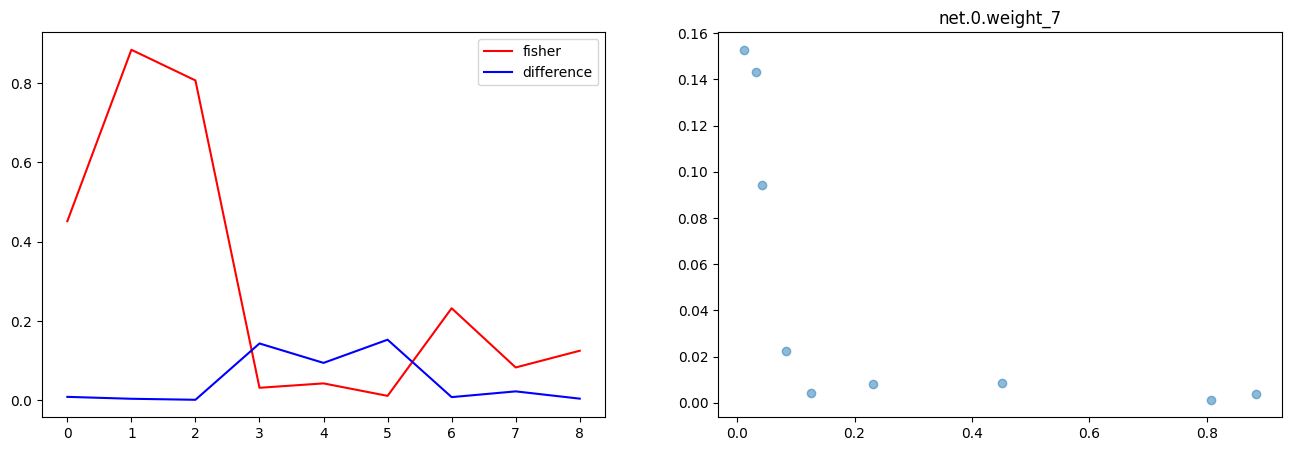

Max fisher is 1.06929 and it's parameter diff is 0.00229
Min Parameter diff is 0.06587 and it's fisher is 0.04281
fisher > parameter diff: 8
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

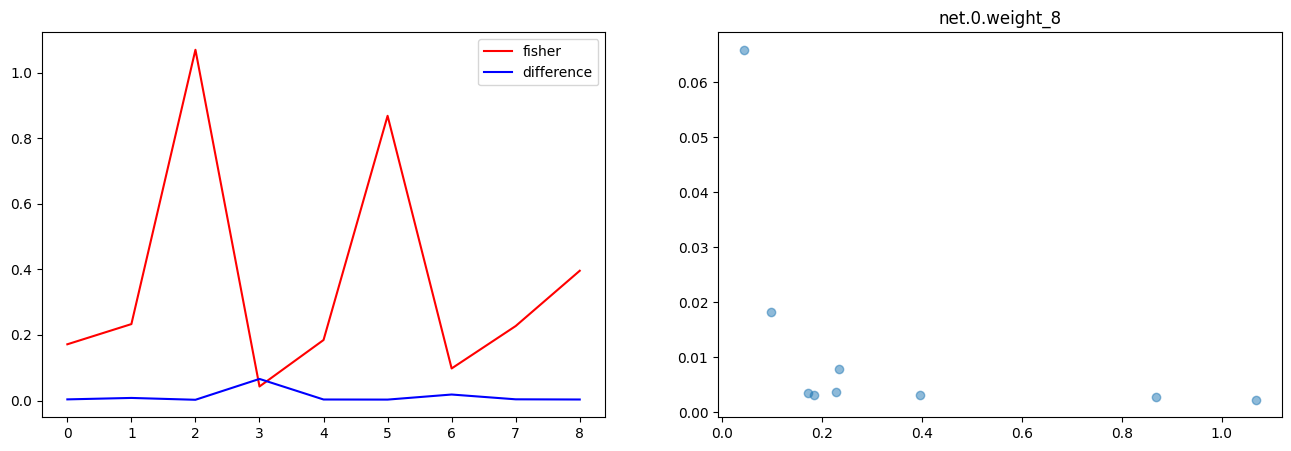

Max fisher is 0.67797 and it's parameter diff is 0.00073
Min Parameter diff is 0.04767 and it's fisher is 0.02153
fisher > parameter diff: 8
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

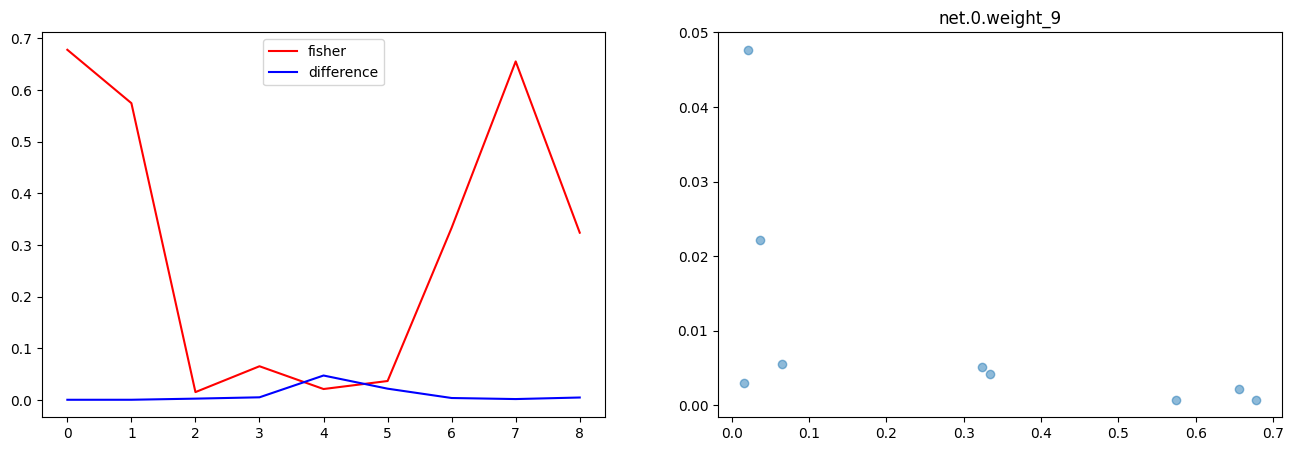


net.0.bias
torch.Size([10])
Max fisher is 11.17209 and it's parameter diff is 0.00113
Min Parameter diff is 0.32332 and it's fisher is 0.00000
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

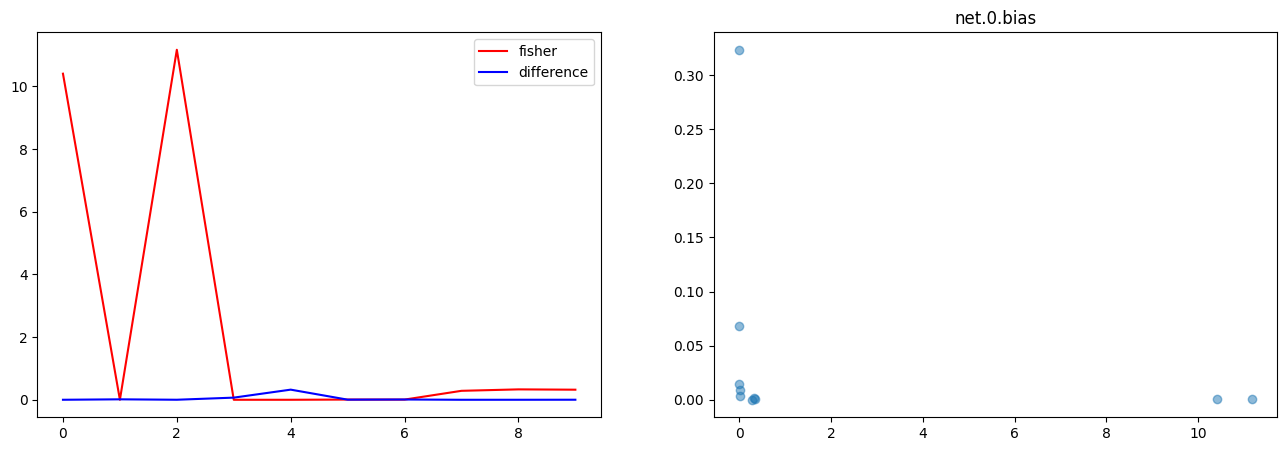


net.3.weight
torch.Size([10])
Max fisher is 0.36927 and it's parameter diff is 0.00405
Min Parameter diff is 0.36516 and it's fisher is 0.00459
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

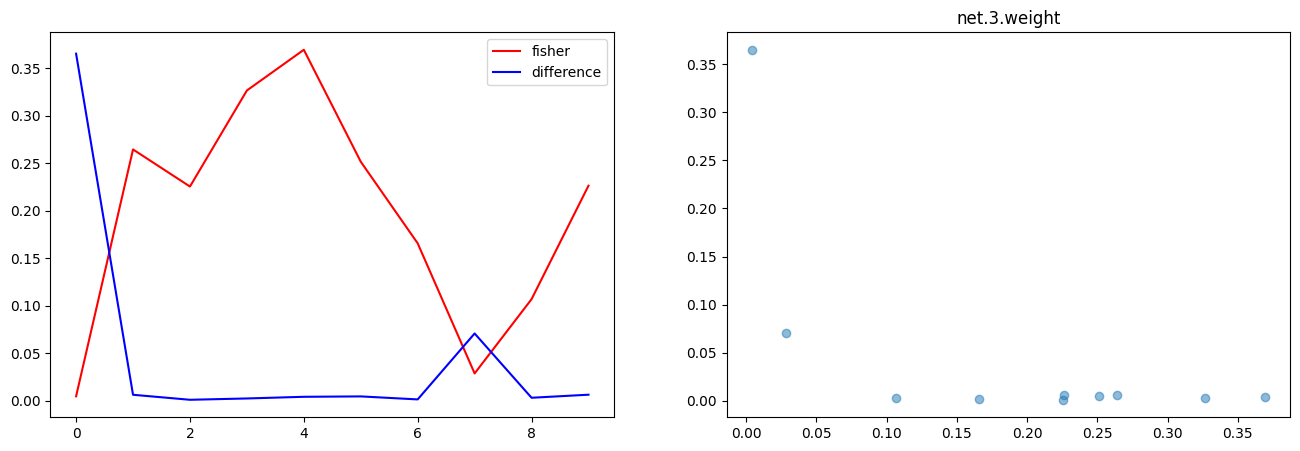


net.3.bias
torch.Size([10])
Max fisher is 0.11488 and it's parameter diff is 0.00381
Min Parameter diff is 0.55687 and it's fisher is 0.00068
fisher > parameter diff: 3
fisher <= parameter diff: 7


<Figure size 640x480 with 0 Axes>

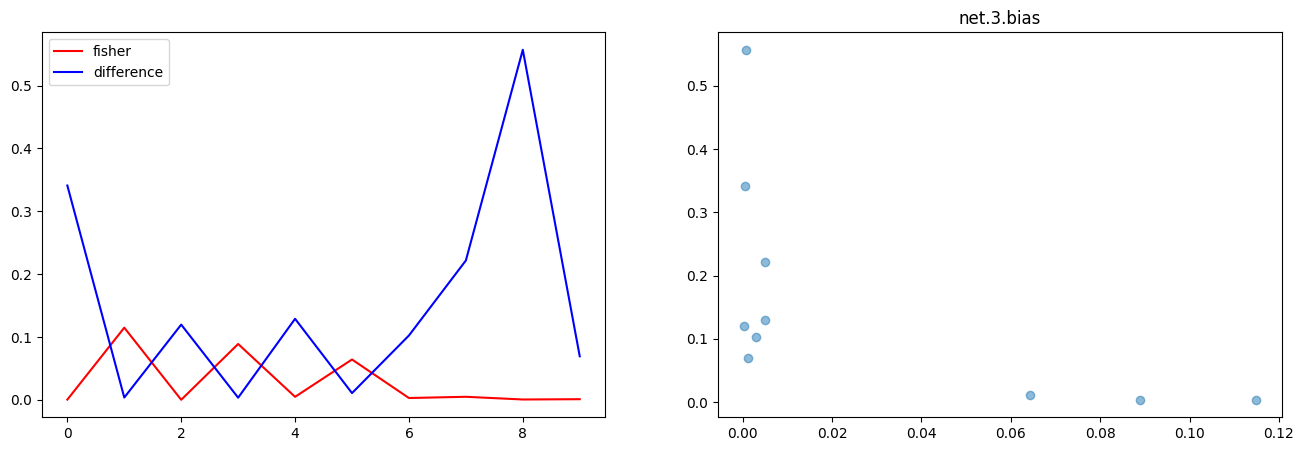


net.4.weight
torch.Size([5, 10, 3, 3])
Max fisher is 6.08721 and it's parameter diff is 0.00055
Min Parameter diff is 0.12104 and it's fisher is 0.01508
fisher > parameter diff: 80
fisher <= parameter diff: 10


<Figure size 640x480 with 0 Axes>

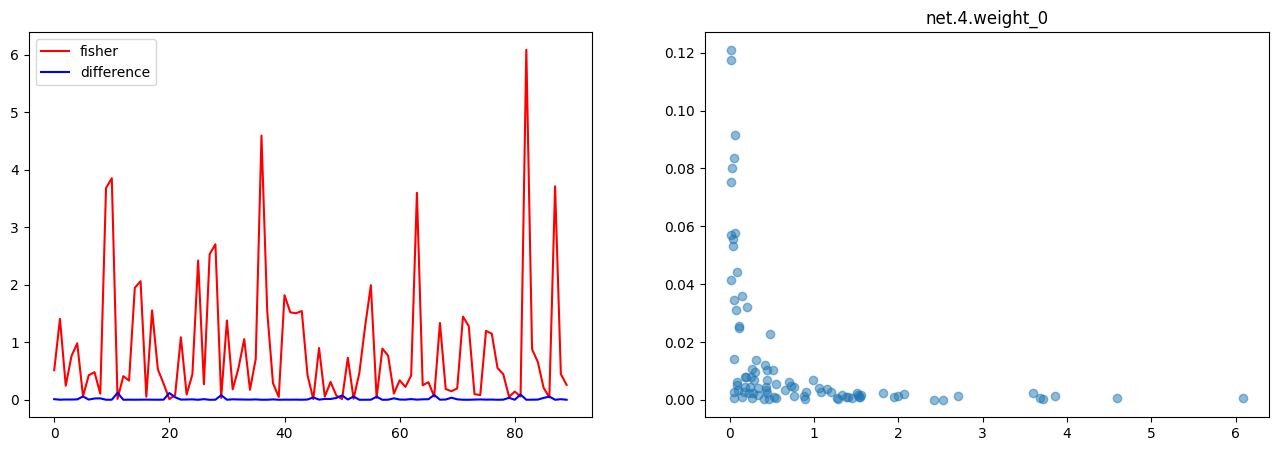

Max fisher is 10.56871 and it's parameter diff is 0.00011
Min Parameter diff is 0.12687 and it's fisher is 0.01028
fisher > parameter diff: 85
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

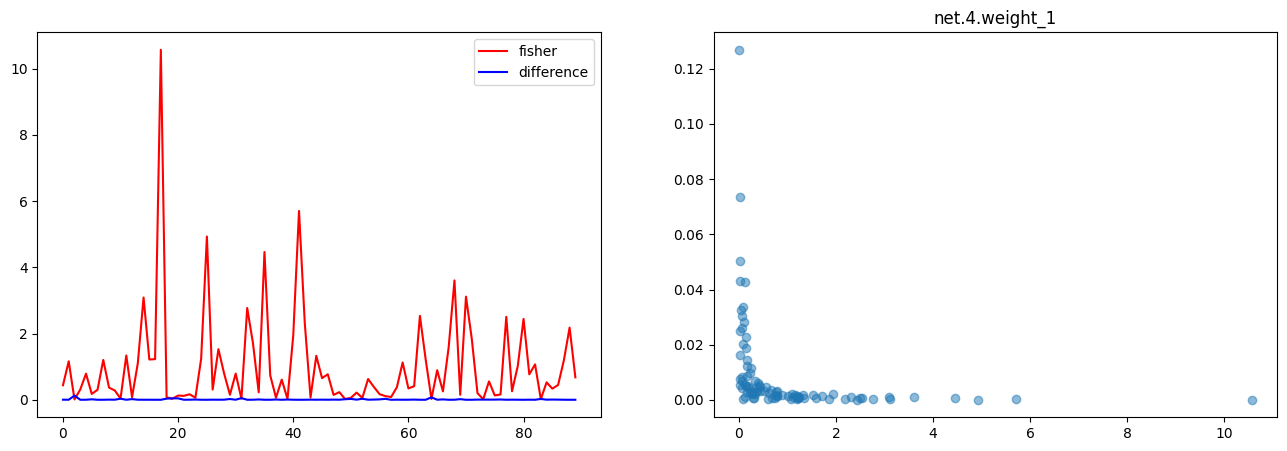

Max fisher is 11.83574 and it's parameter diff is 0.00001
Min Parameter diff is 0.10341 and it's fisher is 0.02746
fisher > parameter diff: 85
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

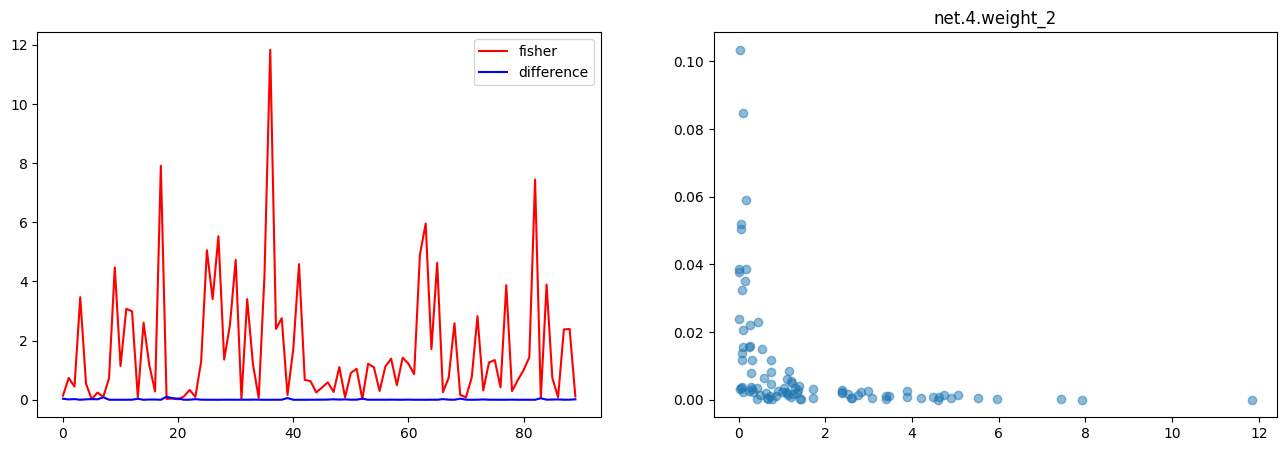

Max fisher is 4.09972 and it's parameter diff is 0.00042
Min Parameter diff is 0.18683 and it's fisher is 0.02764
fisher > parameter diff: 81
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

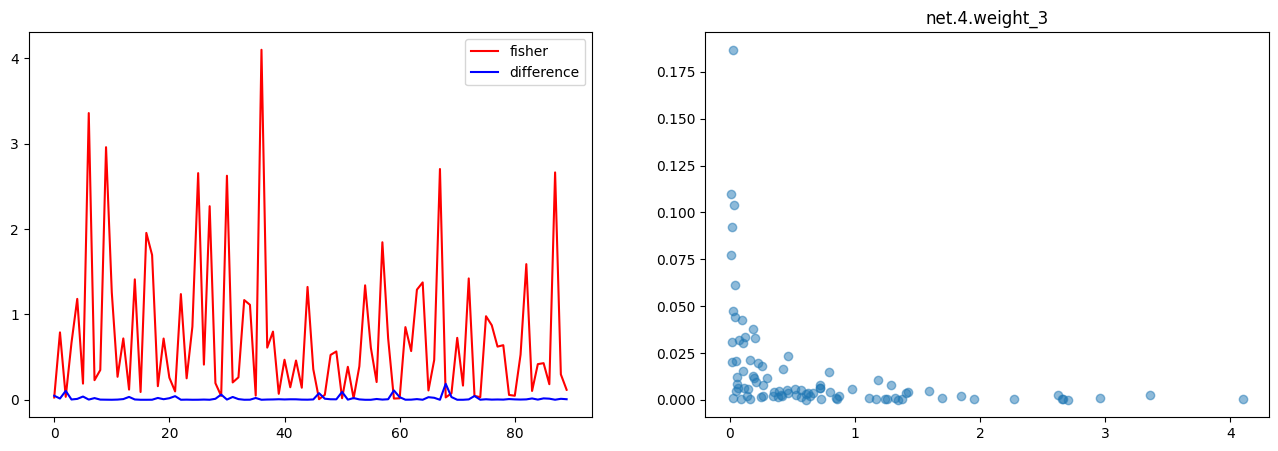

Max fisher is 2.22914 and it's parameter diff is 0.00071
Min Parameter diff is 0.14044 and it's fisher is 0.02726
fisher > parameter diff: 81
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

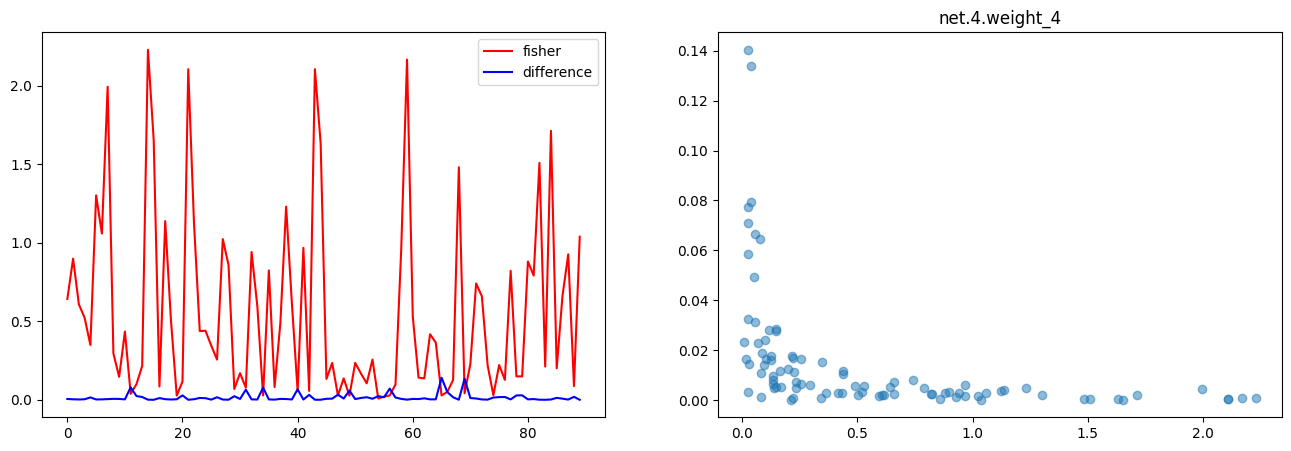


net.4.bias
torch.Size([5])
Max fisher is 0.01441 and it's parameter diff is 0.01171
Min Parameter diff is 0.36220 and it's fisher is 0.00060
fisher > parameter diff: 1
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

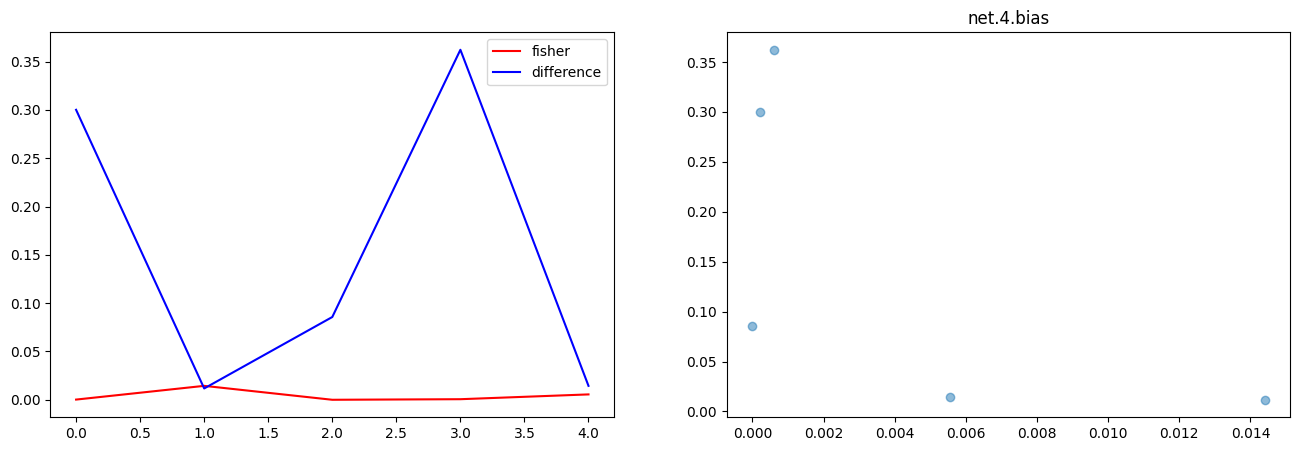


net.7.weight
torch.Size([5])
Max fisher is 1.06803 and it's parameter diff is 0.00038
Min Parameter diff is 0.90479 and it's fisher is 0.00211
fisher > parameter diff: 3
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

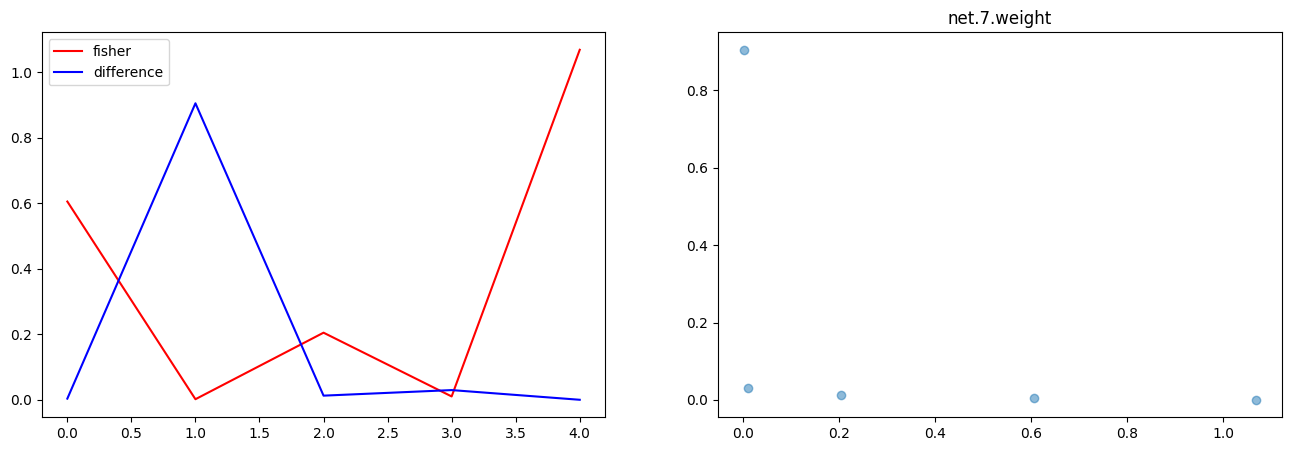


net.7.bias
torch.Size([5])
Max fisher is 0.42357 and it's parameter diff is 0.00275
Min Parameter diff is 0.16527 and it's fisher is 0.00203
fisher > parameter diff: 4
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

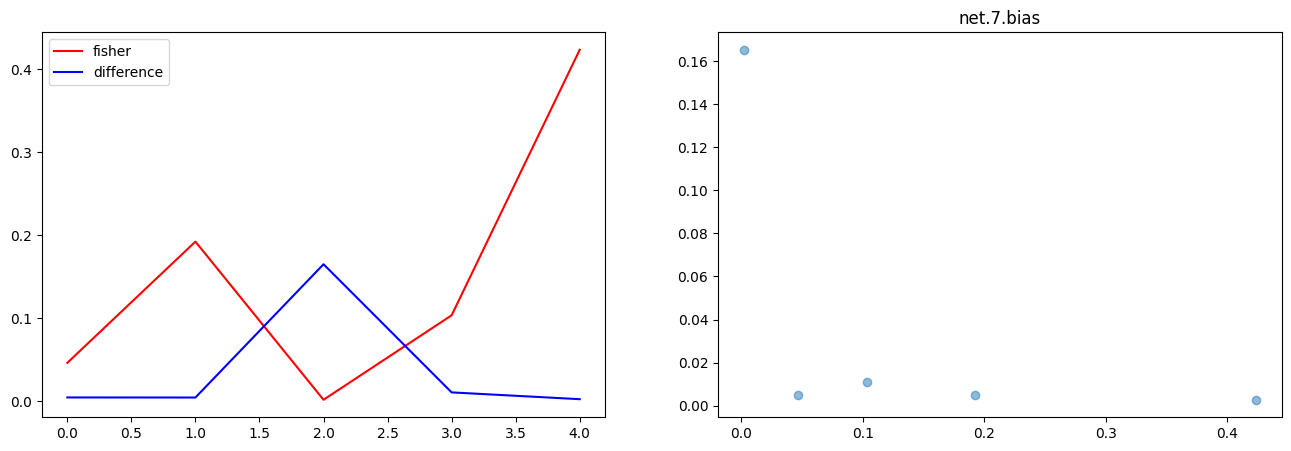


net.9.weight
torch.Size([10, 20])
Max fisher is 0.32371 and it's parameter diff is 0.00243
Min Parameter diff is 0.50531 and it's fisher is 0.00057
fisher > parameter diff: 5
fisher <= parameter diff: 15


<Figure size 640x480 with 0 Axes>

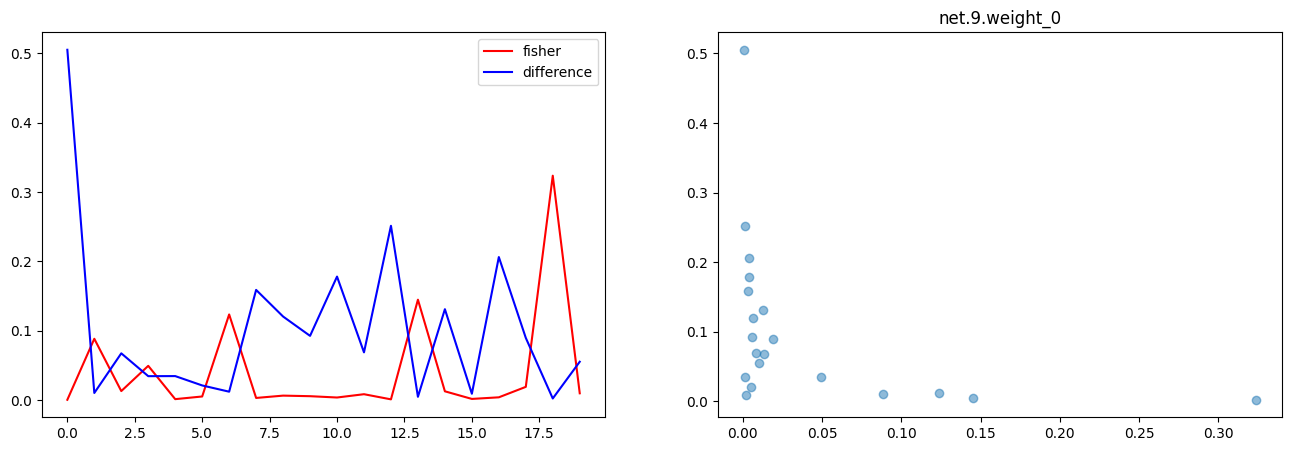

Max fisher is 0.03499 and it's parameter diff is 0.00825
Min Parameter diff is 1.00476 and it's fisher is 0.00057
fisher > parameter diff: 4
fisher <= parameter diff: 16


<Figure size 640x480 with 0 Axes>

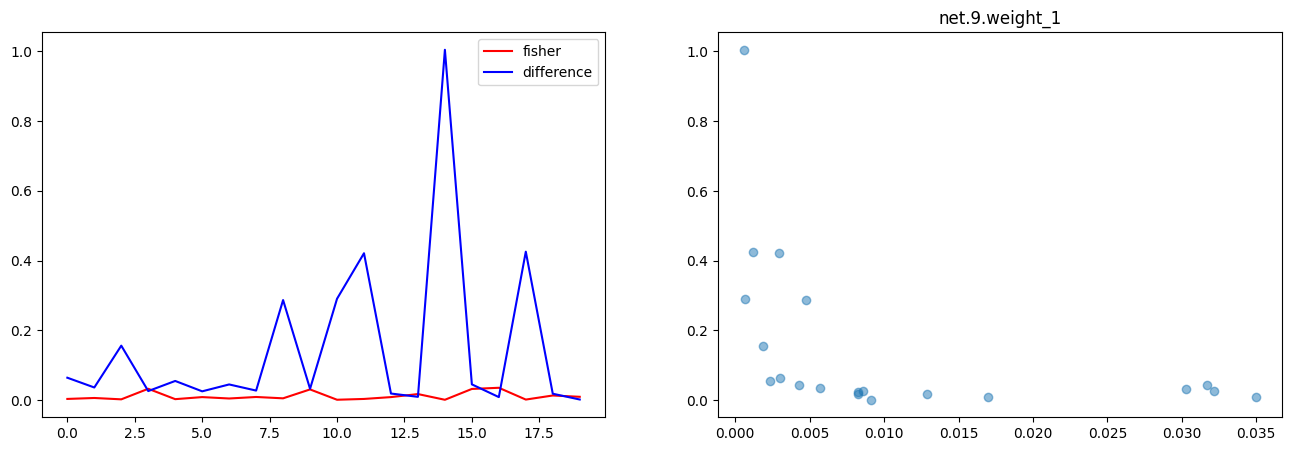

Max fisher is 0.22341 and it's parameter diff is 0.00437
Min Parameter diff is 0.34203 and it's fisher is 0.00323
fisher > parameter diff: 10
fisher <= parameter diff: 10


<Figure size 640x480 with 0 Axes>

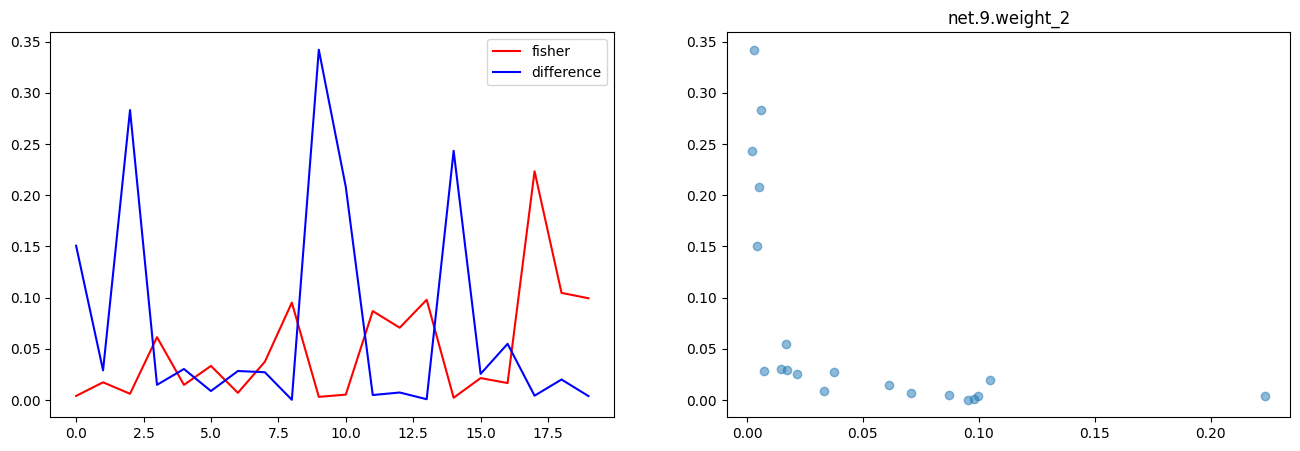

Max fisher is 0.40808 and it's parameter diff is 0.00046
Min Parameter diff is 0.29160 and it's fisher is 0.00109
fisher > parameter diff: 15
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

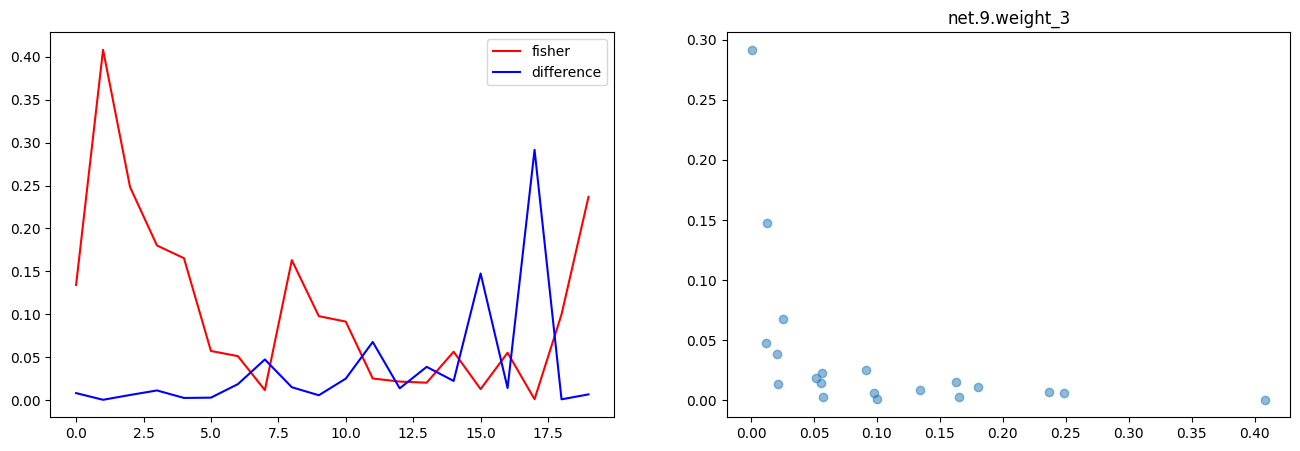

Max fisher is 0.07271 and it's parameter diff is 0.02168
Min Parameter diff is 1.29500 and it's fisher is 0.00103
fisher > parameter diff: 8
fisher <= parameter diff: 12


<Figure size 640x480 with 0 Axes>

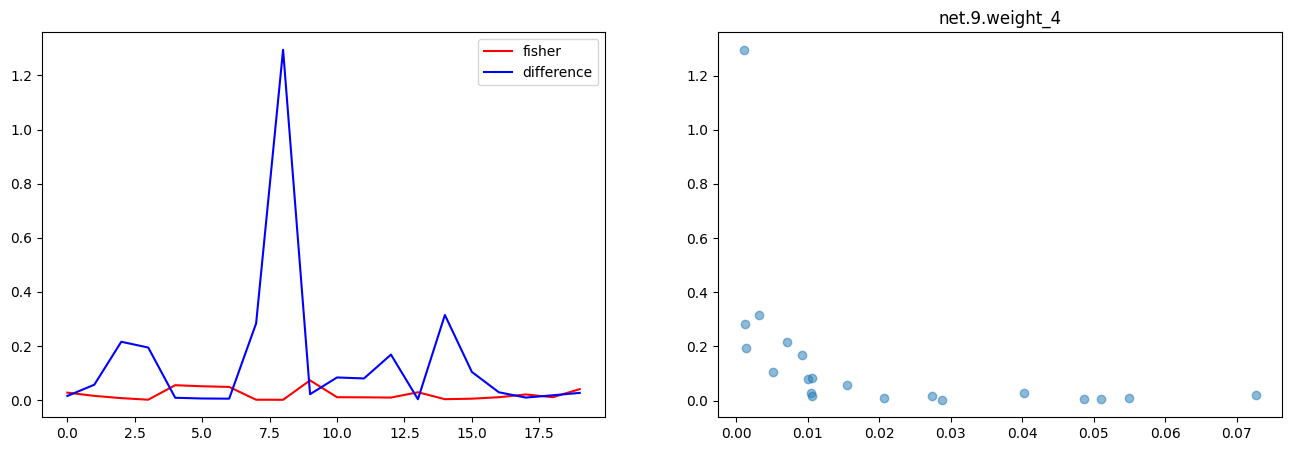

Max fisher is 0.37462 and it's parameter diff is 0.00315
Min Parameter diff is 0.74528 and it's fisher is 0.00154
fisher > parameter diff: 13
fisher <= parameter diff: 7


<Figure size 640x480 with 0 Axes>

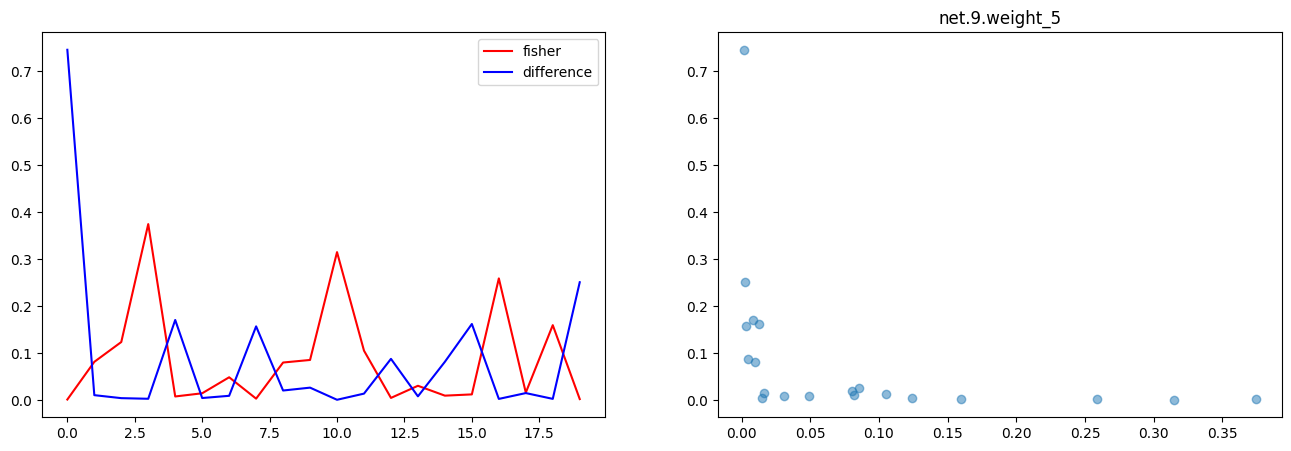

Max fisher is 0.05248 and it's parameter diff is 0.01381
Min Parameter diff is 1.00087 and it's fisher is 0.00072
fisher > parameter diff: 5
fisher <= parameter diff: 15


<Figure size 640x480 with 0 Axes>

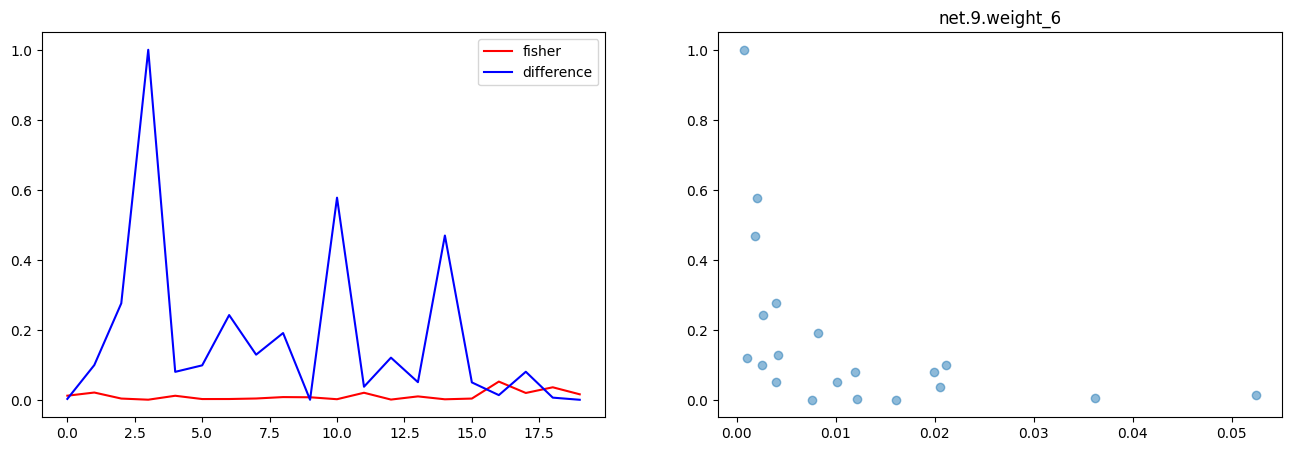

Max fisher is 0.21834 and it's parameter diff is 0.00409
Min Parameter diff is 0.94830 and it's fisher is 0.00038
fisher > parameter diff: 10
fisher <= parameter diff: 10


<Figure size 640x480 with 0 Axes>

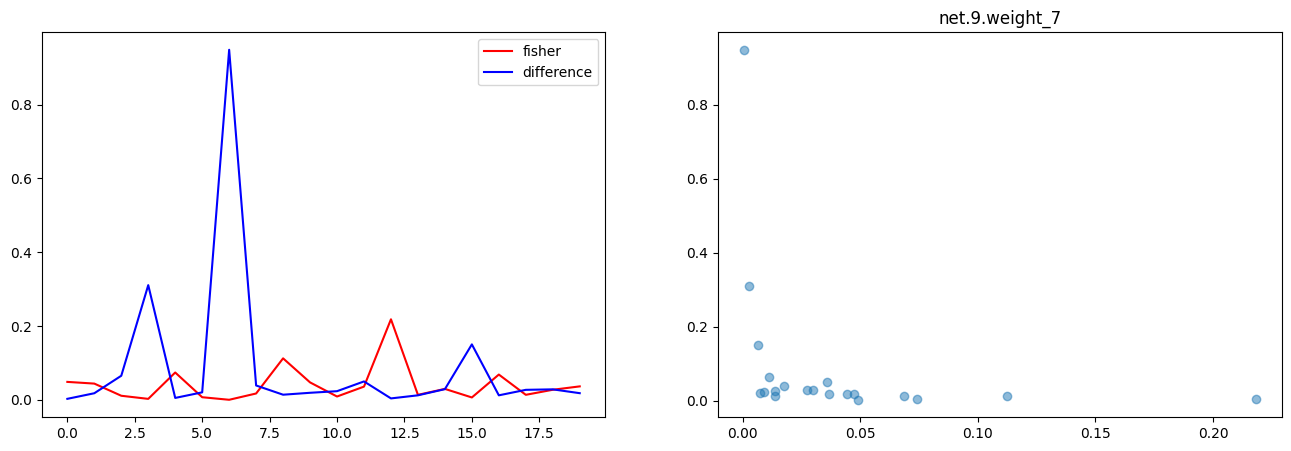

Max fisher is 0.56666 and it's parameter diff is 0.00153
Min Parameter diff is 0.58539 and it's fisher is 0.00201
fisher > parameter diff: 13
fisher <= parameter diff: 7


<Figure size 640x480 with 0 Axes>

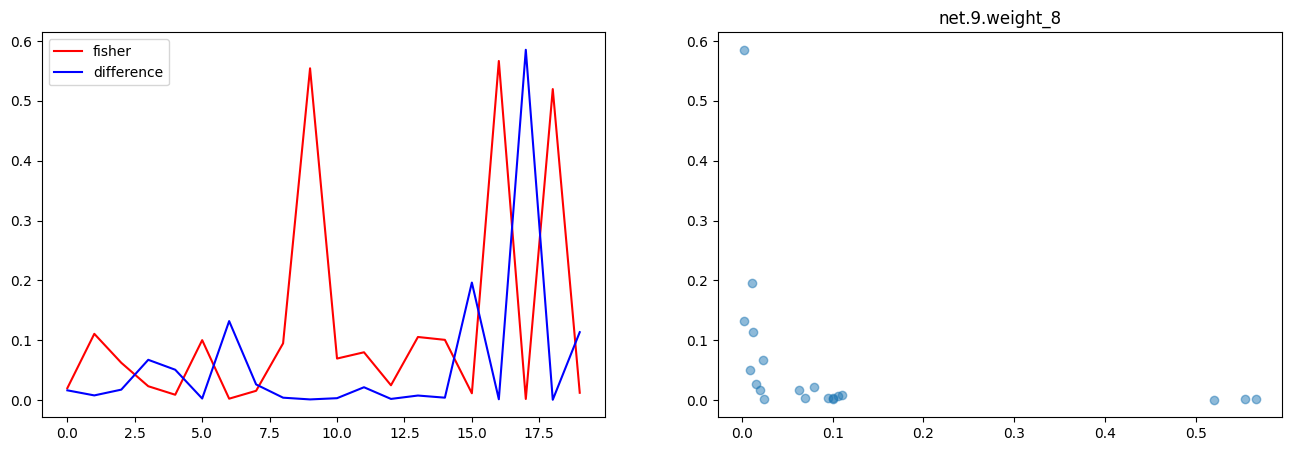

Max fisher is 0.17378 and it's parameter diff is 0.00032
Min Parameter diff is 0.25042 and it's fisher is 0.00133
fisher > parameter diff: 10
fisher <= parameter diff: 10


<Figure size 640x480 with 0 Axes>

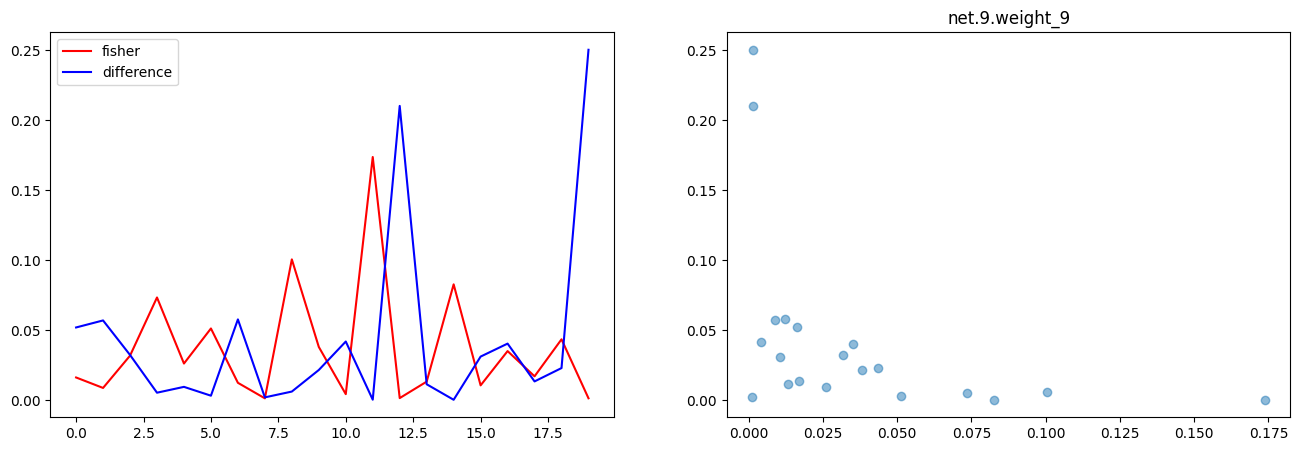


net.9.bias
torch.Size([10])
Max fisher is 0.08879 and it's parameter diff is 0.00232
Min Parameter diff is 0.10981 and it's fisher is 0.00160
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

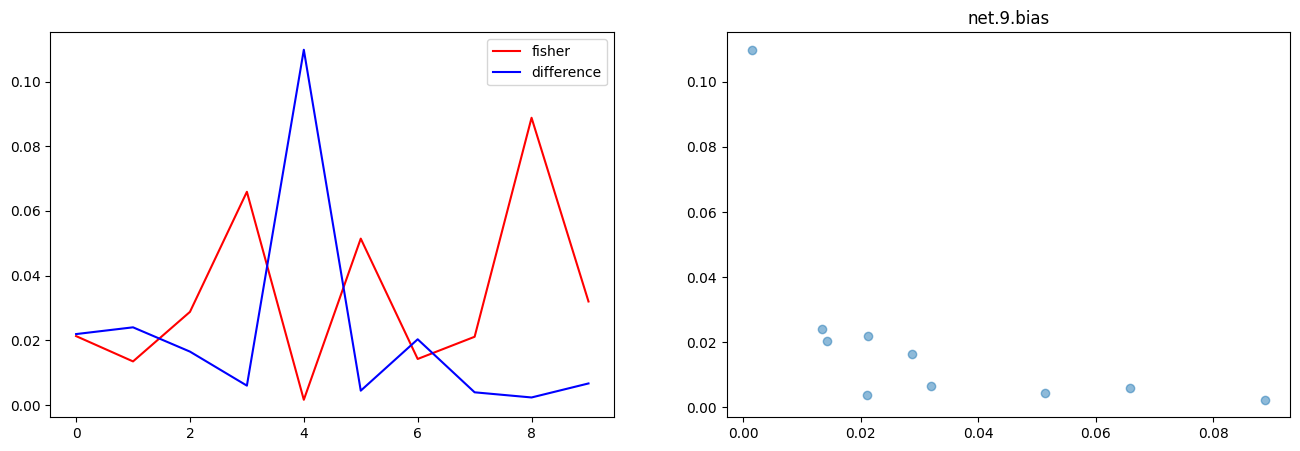

In [98]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i].flatten(), optim_para[0][name][i].flatten(), param[i].flatten(), f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [99]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_22_28_07
